In [22]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.models.particle_filter import ParticleFilterMLP



In [23]:
from src.models.normal import NormalDegradationModel 
model = NormalDegradationModel()
param_names = list(model.state_dict().keys())
param_names

['m0_raw', 'm1_raw', 'p_raw', 'v0_raw', 'v1_raw', 'onset']

In [24]:
net_out_names = [p.replace('_raw','_noise') for p in param_names[:-1]]
net_out_names += ['tempered_correct']

In [ ]:
data_name = "DS03"
perform_name = "T48"
device = "cpu"  # or "cuda"

experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'

In [26]:
net = ParticleFilterMLP(state_dim=5,hidden_dims=[128, 128, 32])

net.load_state_dict(
    torch.load(
        # states_dir / perform_name / "best_pf_net.pt",
        "broken_pf_net.pt",
        map_location=device,
    )
)

net = net.to(device)
net.eval()    # or net.train()

ParticleFilterMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)

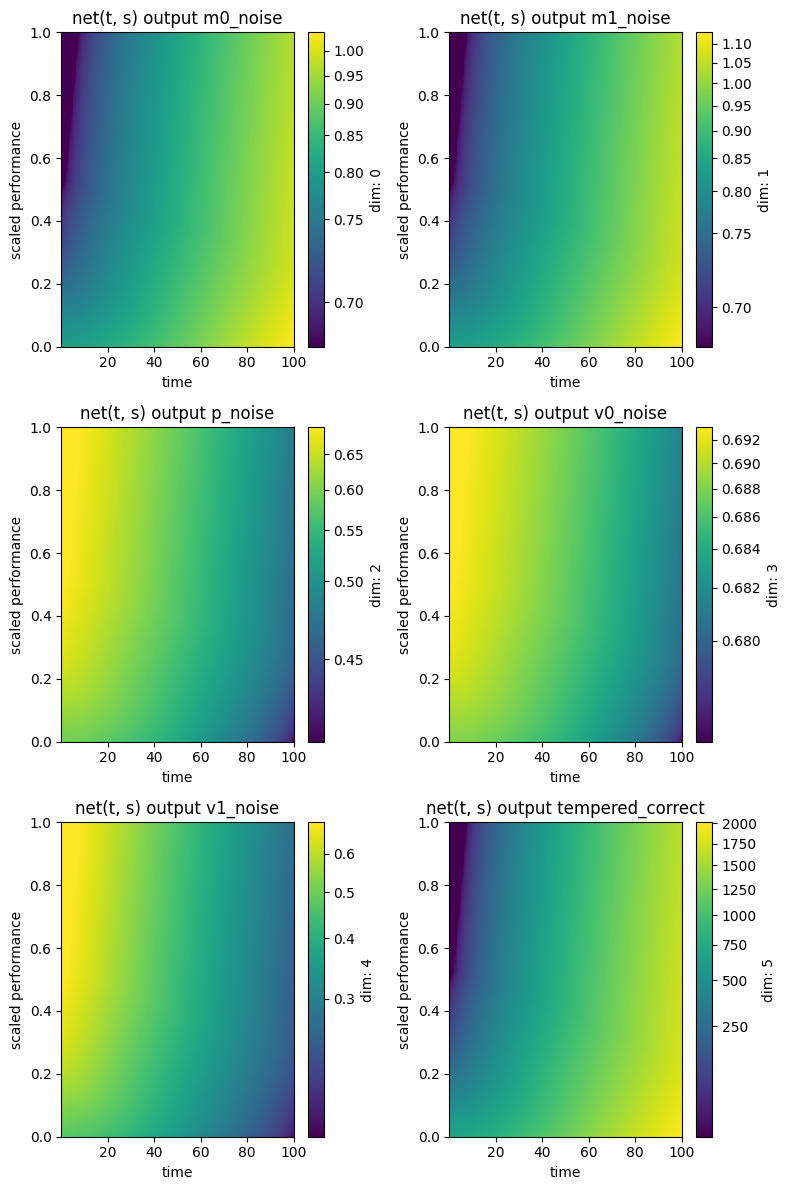

In [27]:
t_grid = np.linspace(0.1, 100, 300)
s_grid = np.linspace(0.0, 1.0, 200)

net.eval()

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
vmax = 5*[None]+ [None]
for i in range(6):
	net.plot_output(
		t=t_grid,
		s=s_grid,
		dim=i,
  		vmax=vmax[i],
		ax=axes[i//2, i%2],
		title=f"net(t, s) output {net_out_names[i]}",
	)


plt.tight_layout()
plt.show()

In [28]:
t=t_grid
s=s_grid
device = next(net.parameters()).device

# ---- grid ----
T, S = np.meshgrid(t, s)
t_torch = torch.tensor(T.flatten(), dtype=torch.float32, device=device)
s_torch = torch.tensor(S.flatten(), dtype=torch.float32, device=device)

# ---- forward (positive outputs) ----
noise,correct = net.tuple_logforward(t_torch,s_torch)  # exp to ensure positivity
correct.max()

tensor(2013.5044, grad_fn=<MaxBackward1>)